In [18]:
"""
Implementation of Milestone 1 and 2
Basis of our LB simulation with collision and streaming implemented
Parameters are defined and explained below  
"""

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [19]:
# Parameters

# Grid size in x and y directions 
Nx = 50
Ny = 50

# an initial average density used for initialization
rhoInitial = 1

# omega used for collision calculation to control the time needed to reach equilibrium state 
# equivalent to 1/tau
# smaller omega --> slower collisions to reach eq --> high viscosity (dickflüssig)
# larger omega --> faster collisions
omega = 1

In [20]:
# we are modeling LB with 9 directions, setting index will be handy later 
NL = 9
idxs = np.arange(NL)

# velocity vectors, splitted into x and y vectors
cxs = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])
cys = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])

# weights we use
weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) 
# weights should add up to one
assert(np.sum(weights) == 1)

In [21]:
"""
F is the matrix used to calculate density and velocity field 
The first axis represents the y coordinate of the grid, the second represents the x coordinate (CARE: its (y,x) so the representation is more intuitive)
Further the third axis represents the directions (degrees of freedom) we use, that means each lattice points has an array of 9 used for calculations later  

[       x0         x1         x2
  [ [ [0..8] ] [ [0..8] ] [ [0..8] ] ] y0
  [ [ [0..8] ] [ [0..8] ] [ [0..8] ] ] y1
  [ [ [0..8] ] [ [0..8] ] [ [0..8] ] ] y2
]

Example visualization of F
"""

# Initialization of F 
F = np.ones((Ny,Nx,NL))

# calculates density for each lattice point over third axis of F 
# that means to sum up the 9 density values of each lattice point 
def calculateDensity(): 
  rho = np.sum(F,2)
  return rho

rho = calculateDensity()

# calculates the velocity at each lattice point by doint the same calculation as for density but multiplied by our 
# velocity vectors and dividing by the density 
# returns tuple of array which hold x respectively y value for each lattice point 
def calculateVelocity():
  ux = np.sum(F*cxs,2) / rho
  uy = np.sum(F*cys,2) / rho
  return (ux,uy)

ux, uy = calculateVelocity()

# mass of the fluid, can be used to verify mass conservation between timesteps
def mass():
  return np.sum(rho)

# Prep figure
fig = plt.figure(figsize=(4,2), dpi=80)

xaxis = np.linspace(0, Nx, Nx)
yaxis = np.linspace(0, Ny, Ny)
X, Y = np.meshgrid(xaxis, yaxis)

<Figure size 320x160 with 0 Axes>

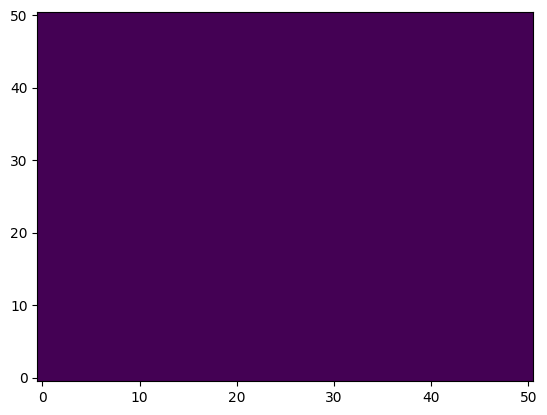

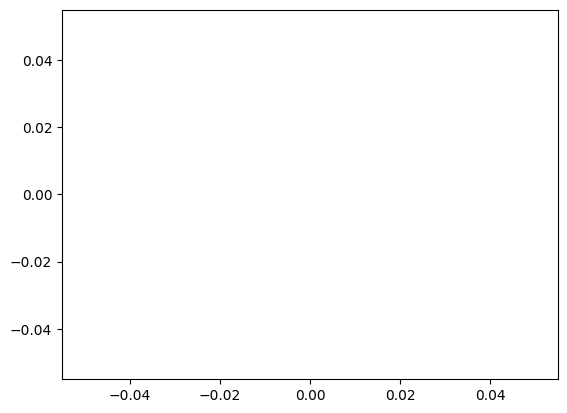

In [22]:
# At every n*STEPS, an image of the plot is saved 
STEPS = 20

# Visualization of density grid 
densityFig, densityAx = plt.subplots()
densityFigureMesh = densityAx.pcolormesh(X, Y, rho, shading='auto')
densityFig.savefig(f'plots/basic/density_timestep{0}.png')
display.display(densityFig)
display.clear_output(wait=True)

# function to update the density meshgrid 
def updateDensityFigure(density, timestep = 0):
    if timestep % STEPS == 0:
        densityAx.set_title(f"timestep: {timestep} omega: {omega}")
        densityFigureMesh.update({'array':density})
        densityFig.savefig(f'plots/basic/density_timestep{timestep}.png')
        display.display(densityFig)
        display.clear_output(wait=True)    


# Visualization for velocity field using a streamplot 
velocityFig, velocityAx = plt.subplots()
velocityStreamPlot = velocityAx.streamplot(X, Y, ux, uy, density = 0.5)
velocityFig.savefig(f'plots/basic/velocity_timestep{0}.png')
display.display(velocityFig)
display.clear_output(wait=True)

# function to update the velocity field grid 
def updateVelocityFigure(ux,uy, timestep = 0):
    if timestep % STEPS == 0:
        velocityAx.set_title(f"timestep: {timestep} omega: {omega}")
        velocityAx.cla()
        velocityAx.streamplot(X, Y, ux, uy, density = 0.5)  
        velocityFig.savefig(f'plots/basic/velocity_timestep{timestep}.png')
        display.display(velocityFig)
        display.clear_output(wait=True)

In [23]:
# Streaming function
# For each lattice point and each direction i, the value in Fi is shifted to the neighbor lattice side 
def streaming():     
  global F
  for i, cx, cy in zip(idxs, cxs, cys):
    F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
    F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)

def collision():
  global F
  Feq = np.zeros(F.shape)
  # calculate the local equilibrium for each lattice point by given equation
  # mind that rho and cx,cy have to be recalculated after streaming before using this function
  for i, cx, cy, w in zip(idxs, cxs, cys, weights):
    Feq[:,:,i] = rho*w* (1 + 3*(cx*ux+cy*uy) + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2)

  # simulate collisions 
  # basically each lattice point gets added a fraction of its difference to the equilibrium  
  # the fraction is controlled by the omega value with the following interpretation 
  # smaller omega --> slower collisions to reach eq --> high viscosity
  # larger omega --> faster collisions
  F += omega * (Feq - F)

In [24]:
# Simulation
def simulate(timesteps=1000, showDensityPlot=True, showVelocityPlot=True):
  global rho, ux, uy

  for i in range(timesteps):

    # apply drift/stream
    streaming()

    # Recalc local variables 
    rho = calculateDensity()
    ux, uy  = calculateVelocity()

    # apply collision
    collision()
  
    if showDensityPlot:
      updateDensityFigure(rho, timestep = i)
          
    if showVelocityPlot:
      updateVelocityFigure(ux,uy, timestep = i)

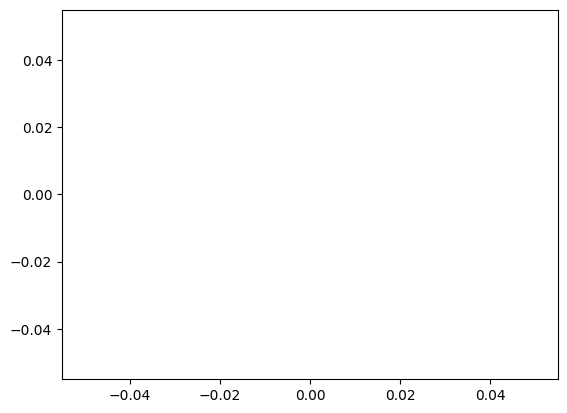

In [25]:
# care to run all cells else F is not reset 
simulate(timesteps=501, showDensityPlot = False, showVelocityPlot = True)